# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before

2. Analyze molecules, QMC versus DFT 

3. Analyze dimers binding energies \
    a. Preliminary plots in FIG03a \

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper


In [3]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from def_colors import map_DMC, dmc_color, dft_color

from define_setup import *

# Read mol_info
with open( 'mol_info.pkl', 'rb' ) as f:
    mol_info = pickle.load( f )
#mol_info

df_mol_info = pd.read_csv( 'mol_info.csv', index_col=0 )
print('*** df_mol_info ***')
print(df_mol_info)

# Read results monomer
import pickle
with open( dir_analysis+'results_mol.pkl', 'rb' ) as f:
    results_mol = pickle.load( f )

# Read mol_info
with open( 'dim_info.pkl', 'rb' ) as f:
    dim_info = pickle.load( f )
#dim_info

df_dim_info = pd.read_csv( 'dim_info.csv', index_col=0 )
print('\n*** df_dim_info ***')
print(df_dim_info)

import pickle
with open( dir_analysis+'results_dim.pkl', 'rb' ) as f:
    results_dim = pickle.load( f )

# results_dim[ dim_id ][ dmc_type ][ tau ] 
# results_dim[1]#['DMCdla5']['0.01']

*** df_mol_info ***
               ref   test          name              formula  \
mol                                                            
AcNH2         21_1   True     acetamide           H3C-CO-NH2   
AcOH          20_1   True   acetic acid             H3C-COOH   
Benzene       24_1  False       benzene                 C6H6   
Cyclopentane  37_1   True  cyclopentane               (CH2)5   
Ethene        30_2  False        ethene              H2C=CH2   
Ethyne        32_2  False        ethyne              HC---CH   
MeNH2         56_2  False   methylamine              H3C-NH2   
MeOH          55_2  False      methanol               H3C-OH   
Neopentane    36_1  False    neopentane              C(CH3)4   
Pentane       34_1  False       pentane  H3C-CH2-CH2-CH2-CH3   
Peptide       57_2   True       peptide        H3C-CO-NH-CH3   
Pyridine      25_1  False      pyridine                NC5H5   
Uracil        26_1   True        uracil             H4C4N2O2   
Water         01_2  

In [4]:
import pickle
with open( dir_analysis+'delta_mol_ref.pkl', 'rb' ) as f:
    delta_mol_ref = pickle.load( f )

# delta_mol_ref[ mol ][ mol_id ] = E[mol_id] - E[ref_mol_id]
# where E is the energy at the B3LYP level

# correct a problem with dimer 35_Neopentane-Pentane
# where 
# Neopentane should be 35_1 but it is 35_2 and
# Pentane sould be 35_2 but it is 35_1

delta_mol_ref['Neopentane']['35_1'] = delta_mol_ref['Neopentane']['35_2']
delta_mol_ref['Pentane']['35_2'] = delta_mol_ref['Neopentane']['35_1']

In [5]:
# TEST MOL
df = pd.DataFrame(results_mol['AcNH2']['21_1']['DMCdla5']['Jopt']).transpose()

# make index a float number
newindex = [float(tau) for tau in df.index]
df['tau'] = newindex
#df.index = newindex
#df.sort_index(ascending=False, inplace=True)

# sort 
df.sort_values(by='tau',ascending=False, inplace=True)
df['mol'] = 'AcNH2'
df
#df[['ene','err']]
#df[ df.index < 0.05 ]
#df[ df.index < 0.05 ]['ene']

,ene,err,units,TotTimeSim[au],Pop,Pop-err,Var[au],tau_eff[au],corr-time[au],machine,N_MPI,cost,target_weight,tau,mol
0.10,-25292.992144,0.030754,kcal/mol,1050.0,63920.817019,1.315471,0.596108,0.088849,0.34311,linuxpc-intel-slurm-parallel.peta4-knl,320,2.067617,64000.0,0.100,AcNH2
0.06,-25290.903243,0.031038,kcal/mol,1230.0,63962.097625,0.994154,0.593015,0.056222,0.273287,linuxpc-intel-slurm-parallel.peta4-icelake-zen,152,0.378622,64000.0,0.060,AcNH2
0.05,-25290.438988,0.029997,kcal/mol,1275.0,63975.752253,0.883435,0.584934,0.047457,0.289681,linuxpc-intel-slurm-parallel.peta4-cclake,112,0.690792,64000.0,0.050,AcNH2
0.04,-25290.159667,0.030095,kcal/mol,1220.0,63974.552628,0.829389,0.591824,0.038443,0.276016,linuxpc-intel-slurm-parallel.peta4-icelake-zen,152,0.379274,64000.0,0.040,AcNH2
0.03,-25289.971374,0.031483,kcal/mol,1215.0,63964.995992,0.72106,0.616691,0.029181,0.307369,linuxpc-intel-slurm-parallel.peta4-knl,320,2.068576,64000.0,0.030,AcNH2
0.02,-25289.92147,0.035623,kcal/mol,1010.0,63977.9592,0.639359,0.599023,0.019673,0.2961,linuxpc-intel-slurm-parallel.peta4-icelake-zen,152,0.378092,64000.0,0.020,AcNH2
0.01,-25289.974516,0.030749,kcal/mol,1005.0,63979.291548,0.451912,0.606618,0.009934,0.256561,linuxpc-intel-slurm-parallel.peta4-knl,320,2.066127,64000.0,0.010,AcNH2
0.003,-25290.211134,0.029811,kcal/mol,1201.5,63992.274424,0.226432,0.618657,0.002996,0.284465,linuxpc-intel-slurm-parallel.peta4-icelake,152,0.351324,64000.0,0.003,AcNH2


In [6]:
#TEST DIMER
#print(results_dim)
df = pd.DataFrame(results_dim[1]['DMCdla5']['Jopt']).transpose()
df['tau'] = [float(tau) for tau in df.index]
df.sort_values(by='tau',ascending=False, inplace=True)
df
#df[['ene','err']]
df.loc[ lambda x: (x.tau <= 0.01) ]
#df.tau <= 0.01

,ene,err,units,TotTimeSim[au],Pop,Pop-err,Var[au],tau_eff[au],corr-time[au],machine,N_MPI,cost,target_weight,tau
0.01,-21603.920124,0.026118,kcal/mol,1005.0,63980.92201,0.433089,0.537514,0.009908,0.196763,linuxpc-intel-slurm-parallel.peta4,128,0.27329,64000.0,0.010
0.003,-21603.974571,0.02526,kcal/mol,1201.5,63994.582792,0.219845,0.540806,0.002995,0.178317,linuxpc-intel-slurm-parallel.peta4,960,0.07915,64000.0,0.003
0.001,-21604.034267,0.024686,kcal/mol,1000.5,63991.396458,0.141569,0.531294,0.001,0.168011,linuxpc-intel-slurm-parallel.peta4-cclake,112,0.333377,64000.0,0.001


In [14]:
# Evaluation of DMC binding energies of all dimers, i=1,...,66, 
# into a Pamdas DataFrame, reporting Eb, error, dmc_type, dmc_Jas, name, ...
# Final DataFrame is obtained from the concatenation of individual dataframes,
# each for a different dimer and a different DMC setup

verbose = False

dfs_dimer=[]
dfs_Eb=[]

for i in range(1,67):
    dim = results_dim[i]
    mol1 = dim_info[i]['mol1']
    mol2 = dim_info[i]['mol2']
    name = dim_info[i]['name']
    # Number of valence electrons
    Nelv1 = mol_info[mol1]['Nelv']
    Nelv2 = mol_info[mol2]['Nelv']
    Nelv = Nelv1 + Nelv2
    print(i, mol1, mol2, name, Nelv)

    # case of molecule depends on:
    # mol1 = mol2?
    # and mol_info[...]['test'] is true/false
    mols_ref = {}
    delta = 0.0
    for j in [1,2]:
        mol = dim_info[i][ f'mol{j}' ]
        mol_id = f'{i:02d}_{j}'
        if mol_info[mol]['test']:
            mols_ref[j] = mol_id
            # delta not changed
        else:
            mols_ref[j] = mol_info[mol]['ref']
            delta += delta_mol_ref[mol][mol_id]
            print('DE structure:',i,j,mol,mol_id,delta_mol_ref[mol][mol_id])
    
    # Identify cases where reference for mol1 and mol2 is the same
    if mols_ref[1]==mols_ref[2]:
        mol_sameref = True
        print('mol_sameref = True')
    else:
        mol_sameref = False

    # read energy dimers
    for dmc_type in dim:
        if dmc_type.startswith('DMC'):
            for Jas in set(dim[dmc_type]):
                print(dmc_type,dmc_Jas)
                d = pd.DataFrame( dim[dmc_type][Jas] ).transpose().sort_index(ascending=False)
                # add column 'tau' and sort
                d['tau'] = [float(tau) for tau in d.index]
                d.sort_values(by='tau',ascending=False, inplace=True)
                # add calumns with name of dimer, index i and dmc_type
                d['name'] = dim_info[i]['name']
                d['i'] = i
                d['dmc_type'] = dmc_type
                d['Jas'] = dmc_Jas
                d['Nelv'] = Nelv
                if verbose: print(d)
                dfs_dimer.append( d )
                for Jas_mol in results_mol[mol1][ mols_ref[1] ][dmc_type]:
                    print(dmc_type,Jas)
                    try:
                        # Compute Eb and error, with different equations if mol_sameref is True or False
                        if mol_sameref:
                            m = pd.DataFrame( results_mol[mol1][ mols_ref[1] ][dmc_type][Jas_mol] ).transpose().sort_index(ascending=False)
                            if verbose: 
                                print(m)
                            df_Eb_ene = d['ene'] - 2*m['ene'] - delta 
                            df_Eb_err = ( d['err']**2 + 4*m['err']**2 )**0.5
                        else:
                            m1 = pd.DataFrame( results_mol[mol1][ mols_ref[1] ][dmc_type][Jas_mol] ).transpose().sort_index(ascending=False)
                            m2 = pd.DataFrame( results_mol[mol2][ mols_ref[2] ][dmc_type][Jas_mol] ).transpose().sort_index(ascending=False)
                            if verbose:
                                print(m1)
                                print(m2)
                            df_Eb_ene = d['ene'] - m1['ene'] - m2['ene'] - delta 
                            df_Eb_err = ( d['err']**2 + m1['err']**2 + m2['err']**2 )**0.5
                        #print( '\n',df_Eb_ene,"\n", df_Eb_err)
                        df_Eb = pd.concat( [df_Eb_ene, df_Eb_err], axis=1 )
                        df_Eb = df_Eb[ df_Eb.ene.notna() ]
                        # Add extra columns for name, index i, dmc_type, Jastrow, delta, tau in floats 
                        df_Eb['name'] = name
                        df_Eb['i'] = i
                        df_Eb['dmc_type'] = dmc_type
                        df_Eb['Jas'] = Jas
                        df_Eb['Jas_mol'] = Jas_mol
                        df_Eb['delta'] = delta
                        df_Eb['tau'] = [float(tau) for tau in df_Eb.index]
                        df_Eb.sort_values(by='tau',ascending=False, inplace=True)
                        dfs_Eb.append( df_Eb )
                        if verbose: 
                            print( df_Eb )
                    except Exception as e:
                        print( f' *** Exception {e} for {name} {i} {dmc_type} {Jas}' )
    print()

Edimer = pd.concat( dfs_dimer, ignore_index=True )
Edimer
Edimer.to_csv('Edimer.csv')

Eb = pd.concat( dfs_Eb, ignore_index=True )
Eb
Eb.to_csv('Eb.csv')


1 Water Water 01_Water-Water 16
DE structure: 1 1 Water 01_1 0.030970661566243507
DE structure: 1 2 Water 01_2 0.0
mol_sameref = True


NameError: name 'dmc_Jas' is not defined

In [15]:
### Eb all with respect to a reference structure in the mol.
# Evaluation of DMC binding energies of all dimers, i=1,...,66, 
# into a Pamdas DataFrame, reporting Eb, error, dmc_type, dmc_Jas, name, ...
# Final DataFrame is obtained from the concatenation of individual dataframes,
# each for a different dimer and a different DMC setup

verbose = False

dfs_Eb=[]

for i in range(1,67):
    dim = results_dim[i]
    mol1 = dim_info[i]['mol1']
    mol2 = dim_info[i]['mol2']
    name = dim_info[i]['name']
    print(i, mol1, mol2, name)

    # case of molecule depends on:
    # mol1 = mol2?
    # and mol_info[...]['test'] is true/false
    mols_ref = {}
    delta = 0.0
    for j in [1,2]:
        mol = dim_info[i][ f'mol{j}' ]
        mol_id = f'{i:02d}_{j}'
        mols_ref[j] = mol_info[mol]['ref']
        delta += delta_mol_ref[mol][mol_id]
        print('DE structure:',i,j,mol,mol_id,delta_mol_ref[mol][mol_id])
    
    # Identify cases where reference for mol1 and mol2 is the same
    if mols_ref[1]==mols_ref[2]:
        mol_sameref = True
        print('mol_sameref = True')
    else:
        mol_sameref = False

    # read energy dimers
    for dmc_type in dim:
        if dmc_type.startswith('DMC'):
            for Jas in set(dim[dmc_type]):
                print(dmc_type)
                d = pd.DataFrame( dim[dmc_type][Jas] ).transpose().sort_index(ascending=False)
                # add column 'tau' and sort
                d['tau'] = [float(tau) for tau in d.index]
                d.sort_values(by='tau',ascending=False, inplace=True)
                # add calumns with name of dimer, index i and dmc_type
                d['name'] = dim_info[i]['name']
                d['i'] = i
                d['dmc_type'] = dmc_type
                d['Jas'] = Jas
                if verbose: print(d)
                dfs_dimer.append( d )
                for Jas_mol in results_mol[mol1][ mols_ref[1] ][dmc_type]:
                    print(dmc_type,Jas)
                    try:
                        # Compute Eb and error, with different equations if mol_sameref is True or False
                        if mol_sameref:
                            m = pd.DataFrame( results_mol[mol1][ mols_ref[1] ][dmc_type][Jas_mol] ).transpose().sort_index(ascending=False)
                            if verbose: 
                                print(m)
                            df_Eb_ene = d['ene'] - 2*m['ene'] - delta 
                            df_Eb_err = ( d['err']**2 + 4*m['err']**2 )**0.5
                        else:
                            m1 = pd.DataFrame( results_mol[mol1][ mols_ref[1] ][dmc_type][Jas_mol] ).transpose().sort_index(ascending=False)
                            m2 = pd.DataFrame( results_mol[mol2][ mols_ref[2] ][dmc_type][Jas_mol] ).transpose().sort_index(ascending=False)
                            if verbose:
                                print(m1)
                                print(m2)
                            df_Eb_ene = d['ene'] - m1['ene'] - m2['ene'] - delta 
                            df_Eb_err = ( d['err']**2 + m1['err']**2 + m2['err']**2 )**0.5
                        #print( '\n',df_Eb_ene,"\n", df_Eb_err)
                        df_Eb = pd.concat( [df_Eb_ene, df_Eb_err], axis=1 )
                        df_Eb = df_Eb[ df_Eb.ene.notna() ]
                        # Add extra columns for name, index i, dmc_type, Jastrow, delta, tau in floats 
                        df_Eb['name'] = name
                        df_Eb['i'] = i
                        df_Eb['dmc_type'] = dmc_type
                        df_Eb['Jas'] = Jas
                        df_Eb['Jas_mol'] = Jas_mol
                        df_Eb['delta'] = delta
                        df_Eb['tau'] = [float(tau) for tau in df_Eb.index]
                        df_Eb.sort_values(by='tau',ascending=False, inplace=True)
                        dfs_Eb.append( df_Eb )
                        if verbose: 
                            print( df_Eb )
                    except Exception as e:
                        print( f' *** Exception {e} for {name} {i} {dmc_type} {Jas}' )
    print()

Eb_1ref = pd.concat( dfs_Eb, ignore_index=True )
Eb_1ref
Eb_1ref.to_csv('Eb_1ref.csv')


1 Water Water 01_Water-Water
DE structure: 1 1 Water 01_1 0.030970661566243507
DE structure: 1 2 Water 01_2 0.0
mol_sameref = True
DMCtm5
DMCtm5 Jopt
DMCtm5 Jopt
DMCtm5
DMCtm5 JoptLA
DMCtm5 JoptLA
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

2 Water MeOH 02_Water-MeOH
DE structure: 2 1 Water 02_1 0.0417951510680723
DE structure: 2 2 MeOH 02_2 -0.015504908878938295
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

3 Water MeNH2 03_Water-MeNH2
DE structure: 3 1 Water 03_1 0.10874608164886013
DE structure: 3 2 MeNH2 03_2 -0.025838691028184257
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

4 Water Peptide 04_Water-Peptide
DE structure: 4 1 Water 04_1 0.08717102249647724
DE structure: 4 2 Peptide 04_2 0.06704907203675248
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

5 MeOH MeOH 05_MeOH-MeOH
DE structure: 5 1 MeOH 05_1 0.05592319286370184
DE structure: 5 2 MeOH 05_2 -0.022470254931249656
mol_sameref = True
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

6 MeOH MeNH2 06_MeOH-MeNH2
DE structure: 6 1 MeOH 06_1 0.22184063358872663
DE structure: 6 2 MeNH2 

DMCdla5 Jopt

51 Ethyne Ethyne 51_Ethyne-Ethyne_TS
DE structure: 51 1 Ethyne 51_1 -0.030219854226743337
DE structure: 51 2 Ethyne 51_2 -0.026148050012125168
mol_sameref = True
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

52 Benzene AcOH 52_Benzene-AcOH_OH-pi
DE structure: 52 1 Benzene 52_1 0.018470864568371326
DE structure: 52 2 AcOH 52_2 -1.2759445201372728
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

53 Benzene AcNH2 53_Benzene-AcNH2_NH-pi
DE structure: 53 1 Benzene 53_1 0.041799982864176854
DE structure: 53 2 AcNH2 53_2 -0.6462552996526938
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

54 Benzene Water 54_Benzene-Water_OH-pi
DE structure: 54 1 Benzene 54_1 0.000253071979386732
DE structure: 54 2 Water 54_2 0.04407047694257926
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

55 Benzene MeOH 55_Benzene-MeOH_OH-pi
DE structure: 55 1 Benzene 55_1 0.003973286249674857
DE structure: 55 2 MeOH 55_2 0.0
DMCdla5
DMCdla5 Jopt
DMCdla5 Jopt

56 Benzene MeNH2 56_Benzene-MeNH2_NH-pi
DE structure: 56 1 Benzene 56_1 -0.0005966298340354115
DE s

In [16]:
# Plot Total Energy for 66 dimers using dataframe Edimer
verbose = False

for i in range(1,67):
    d = Edimer[ Edimer['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    print(dmc_types)
    for dmc_type in dmc_types:
        #print(d)
        d2 = d[ d['dmc_type']==dmc_type ]
        dmc_Jass = set( d2[ 'Jas' ] )
        print(dmc_Jass)
        for Jas in dmc_Jass:
            print( f'{i} {dmc_type} {Jas}' )
            dd = d.loc[ (d['dmc_type']==dmc_type) & (d['Jas']==Jas) ]
            X = dd['tau']
            Y = dd['ene']
            Yerr = dd['err']
            label = f'{map_DMC( dmc_type )} {Jas}'
            c = dmc_color( dmc_type )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o:', label=label , color=c )

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03a/Etot_{i}.png',format='png',dpi=300)

NameError: name 'Edimer' is not defined

In [17]:
# Plot Variance for 66 dimers using dataframe Edimer
verbose = False

for i in range(1,67):
    d = Edimer[ Edimer['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Variance [a.u.]' )
    
    dmc_types = set( d['dmc_type'] )
    print(dmc_types)
    for dmc_type in dmc_types:
        print( f'{i} {dmc_type}' )

        dd = d[ d['dmc_type']==dmc_type ]
        X = dd['tau']
        Y = dd['Var[au]']
        #Yerr = dd['err']
        label = map_DMC( dmc_type )
        c = dmc_color( dmc_type )
        
        #ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
        ax.plot( X, Y, 'o:', label=label , color=c )

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03a/Var_{i}.png',format='png',dpi=300)

NameError: name 'Edimer' is not defined

In [18]:
# Plot info
# Pop,Pop-err,Var[au],tau_eff[au],corr-time[au]
# for 66 dimers using dataframe Edimer
verbose = False

for i in range(1,67):
    d = Edimer[ Edimer['i']==i ]
    #print(d)
    name = dim_info[i]['name']
    #name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots(5,1,sharex=True, figsize=(5, 15) )
    ax[0].set_title( f'{name}' )
    ax[3].set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax[3].set_xlabel( 'DMC timestep [a.u.]' )
    ax[3].set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax[3].set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )

    ax[0].set_ylabel( 'Energy/N_el_valence [a.u.]' )
    ax[1].set_ylabel( 'Variance/Nel_valence [a.u.]' )
    ax[2].set_ylabel( 'Population' )
    ax[3].set_ylabel( 'Effective / Nominal timestep' )
    ax[4].set_ylabel( 'Correlation time [a.u.]' )
    
    dmc_types = set( d['dmc_type'] )
    print(dmc_types)
    for dmc_type in dmc_types:
        print( f'{i} {dmc_type}' )

        dd = d[ d['dmc_type']==dmc_type ]
        mol1 = dim_info[i]['mol1']
        mol2 = dim_info[i]['mol2']
        Nelv = mol_info[mol1]['Nelv'] + mol_info[mol2]['Nelv']

        label = map_DMC( dmc_type )
        c = dmc_color( dmc_type )
        
        X = dd['tau']

        Y = dd['ene'] / Nelv / 627.503
        Yerr = dd['err'] / Nelv / 627.503
        ax[0].errorbar( X, Y, Yerr, fmt='o:', label=label , color=c )
        ax[0].set_ylim([-2.5,-1])

        Y = dd['Var[au]'] / Nelv
        ax[1].plot( X, Y, 'o:', label=label , color=c )
        ax[1].set_ylim([0.013,0.04])
        
        Y = dd['Pop']
        Yerr = dd['Pop-err']
        ax[2].errorbar( X, Y, Yerr, color=c, fmt='o:' )
        ax[2].hlines(64e3,0,len(X),color='black', linestyles='dashdot')#, label='Target')
        ax[2].set_ylim([63820,64050])

        Y = dd['tau_eff[au]'] / dd['tau']
        ax[3].hlines(1,0,len(X),color='black', linestyles='dashdot')#, label='Target')
        ax[3].plot( X, Y, 'o:', label=label , color=c )
        ax[3].set_ylim([0.8,1.03])

        Y = dd['corr-time[au]']
        ax[4].plot( X, Y, 'o:', label=label , color=c )
        ax[4].set_ylim([0.,0.6])


    ax[0].legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03a/Prop_{i}.png',format='png',dpi=300)

NameError: name 'Edimer' is not defined

In [19]:
# Plot Binding Energy for 66 dimers using dataframe Eb
verbose = False

for i in range(1,67):
    d = Eb[ Eb['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Binding energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    for dmc_type in dmc_types:
        dd = d[ d['dmc_type']==dmc_type ]
        Jas_set = set( dd['Jas'] )
        for Jas in Jas_set:
            print( f'{i} {dmc_type} {Jas}' )

            ddd = dd[ dd['Jas']==Jas ]
            X = ddd['tau']
            Y = ddd['ene']
            Yerr = ddd['err']
            label = f'{map_DMC(dmc_type)} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o:', label=label , color=c )

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03a/Eb_{i}.png',format='png')

NameError: name 'Eb' is not defined

1 01_Water-Water
1 DMCtm5 Jopt
1 DMCtm5 JoptLA
1 DMCdla5 Jopt
2 02_Water-MeOH
2 DMCdla5 Jopt
3 03_Water-MeNH2
3 DMCdla5 Jopt
4 04_Water-Peptide
4 DMCdla5 Jopt
5 05_MeOH-MeOH
5 DMCdla5 Jopt
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
7 07_MeOH-Peptide
7 DMCdla5 Jopt
8 08_MeOH-Water
8 DMCdla5 Jopt
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
12 12_MeNH2-Water
12 DMCdla5 Jopt
13 13_Peptide-MeOH
13 DMCdla5 Jopt
14 14_Peptide-MeNH2
14 DMCdla5 Jopt
15 15_Peptide-Peptide
15 DMCdla5 Jopt
16 16_Peptide-Water
16 DMCdla5 Jopt
17 17_Uracil-Uracil_BP
17 DMCdla5 Jopt
18 18_Water-Pyridine
18 DMCdla5 Jopt
19 19_MeOH-Pyridine
19 DMCdla5 Jopt
20 20_AcOH-AcOH
20 DMCtm5 Jopt
20 DMCtm5 JoptLA
20 DMCdla5 Jopt
21 21_AcNH2-AcNH2
21 DMCdla5 Jopt


/var/folders/hj/4_zbmx1s723ckml8ybrrrv6c0000gn/T/ipykernel_75437/501368108.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )


22 22_AcOH-Uracil
22 DMCdla5 Jopt
23 23_AcNH2-Uracil
23 DMCdla5 Jopt
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
25 25_Pyridine-Pyridine_pi-pi
25 DMCdla Jopt
25 DMC Jopt
25 DMCdla5 Jopt
26 26_Uracil-Uracil_pi-pi
26 DMCdla Jopt
26 DMCdla5 Jopt
27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
30 30_Benzene-Ethene
30 DMCdla5 Jopt
31 31_Uracil-Ethene
31 DMCdla5 Jopt
32 32_Uracil-Ethyne
32 DMCdla5 Jopt
33 33_Pyridine-Ethene
33 DMCdla5 Jopt
34 34_Pentane-Pentane
34 DMCdla5 Jopt
35 35_Neopentane-Pentane
35 DMCdla5 Jopt
36 36_Neopentane-Neopentane
36 DMCdla5 Jopt
37 37_Cyclopentane-Neopentane
37 DMCdla5 Jopt
38 38_Cyclopentane-Cyclopentane
38 DMCdla5 Jopt
39 39_Benzene-Cyclopentane
39 DMCdla5 Jopt
40 40_Benzene-Neopentane
40 DMCdla5 Jopt
41 41_Uracil-Pentane
41 DMCdla5 Jopt
42 42_Uracil-Cyclopentane
42 DMCdla5 Jopt
43 43_Uracil-Neopentane
43 DMCdla5 Jopt
44 44_Ethene-Pentane
44 DMCdla5 Jopt
45 45_Ethyne-Pentane


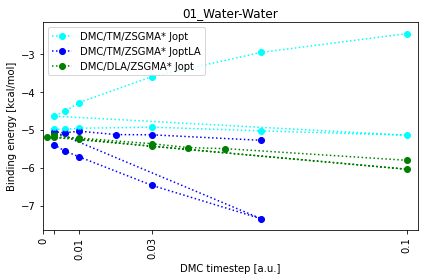

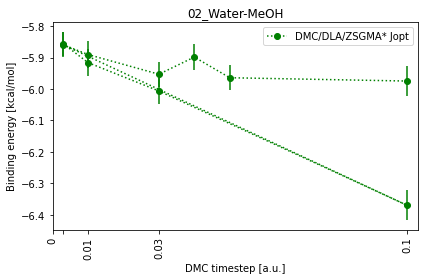

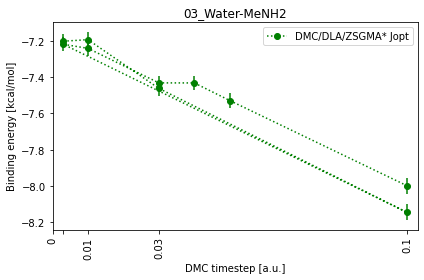

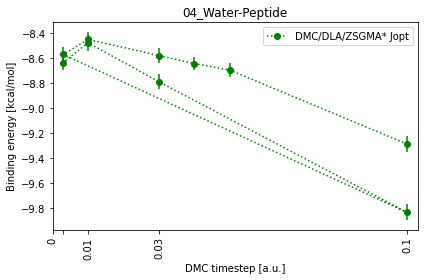

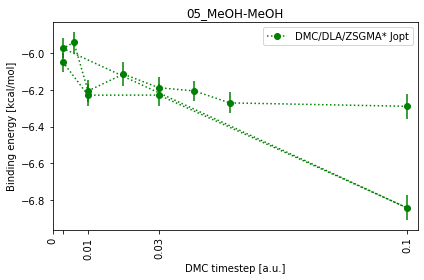

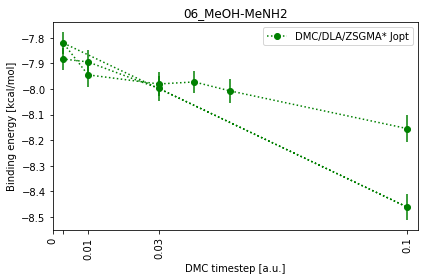

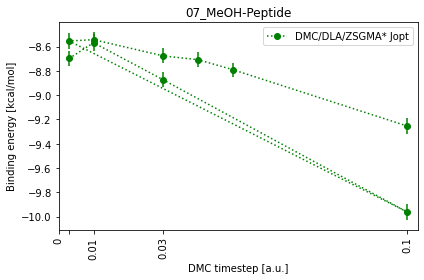

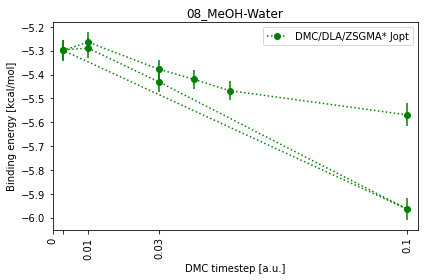

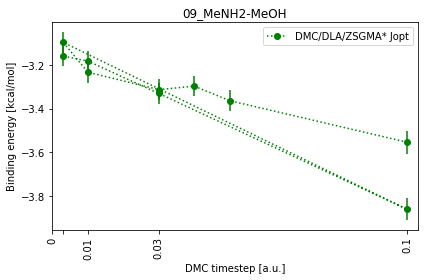

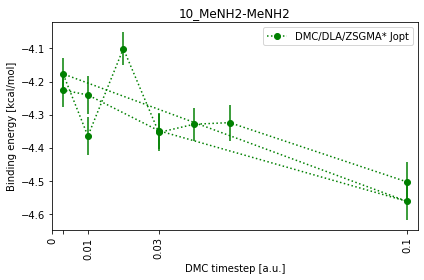

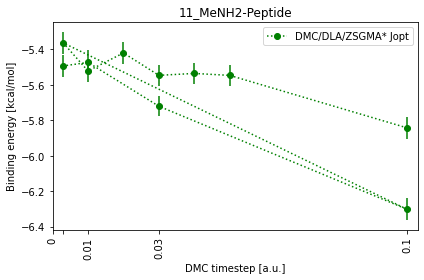

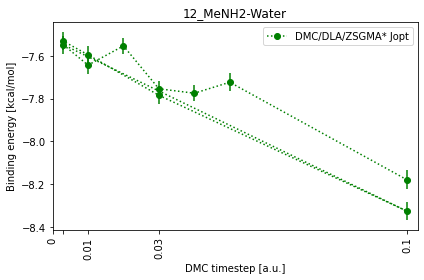

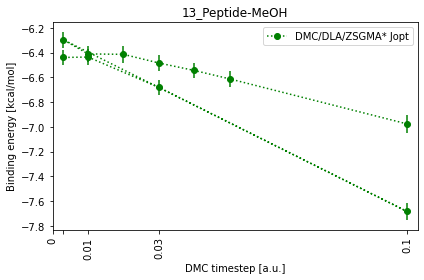

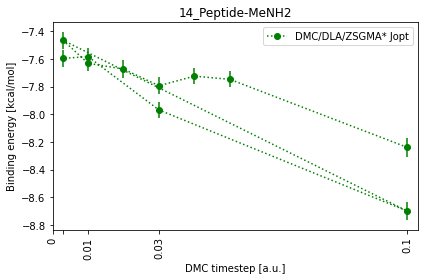

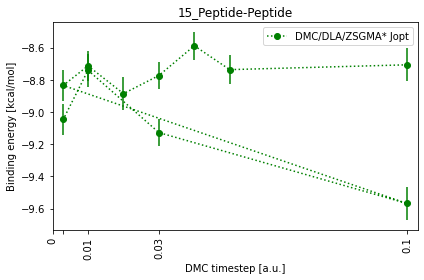

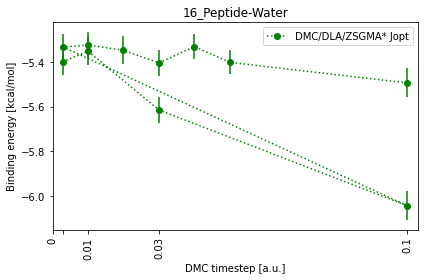

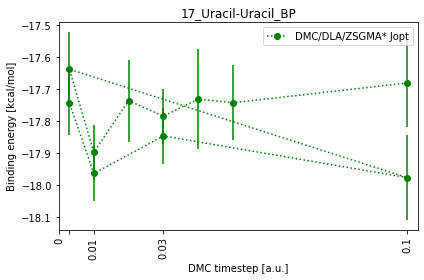

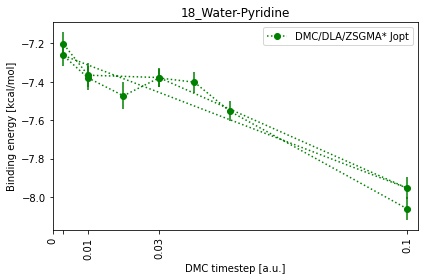

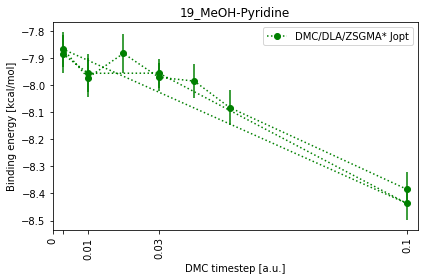

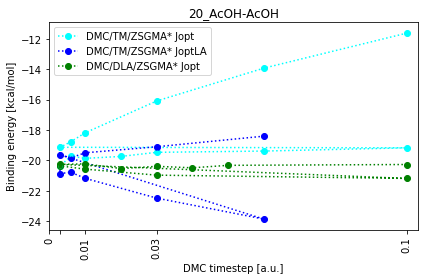

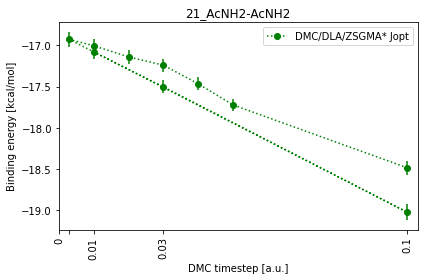

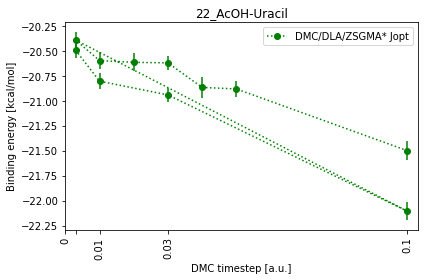

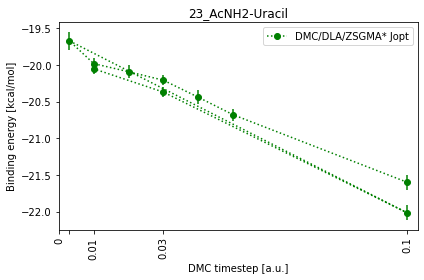

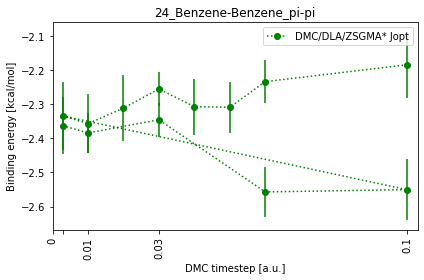

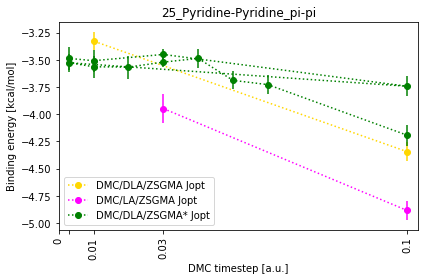

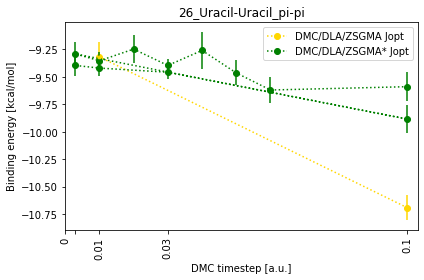

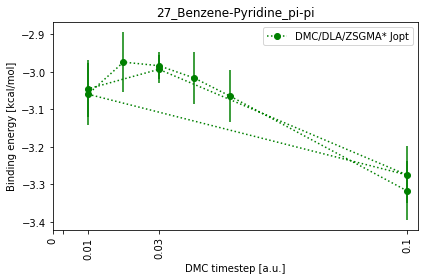

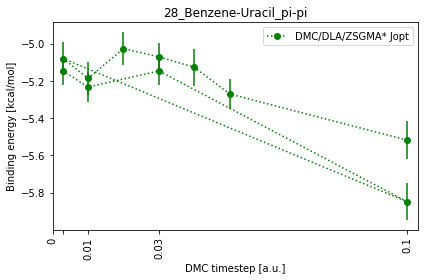

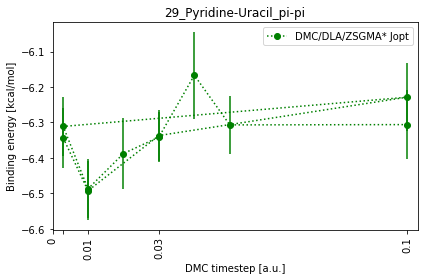

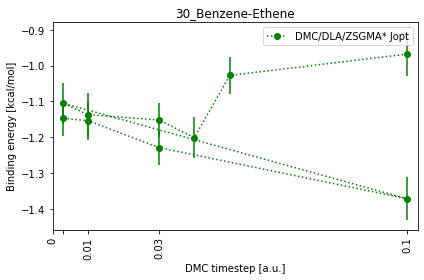

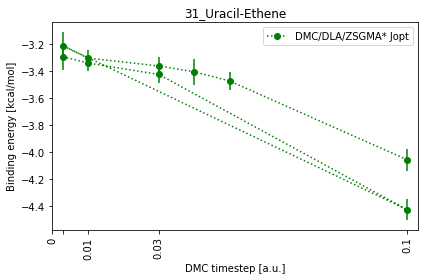

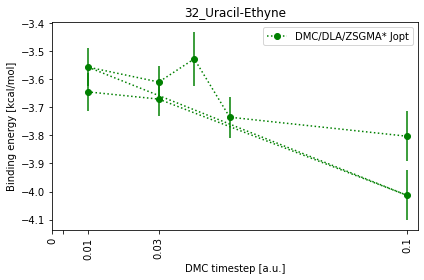

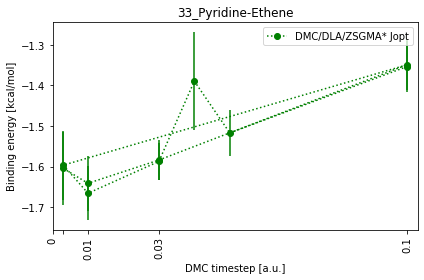

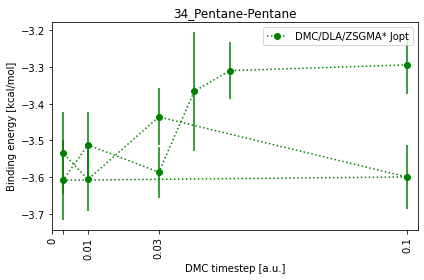

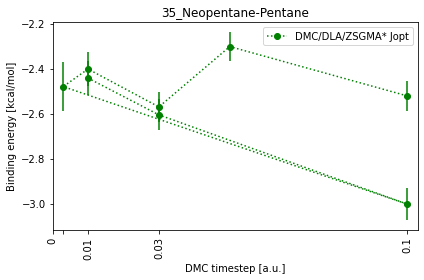

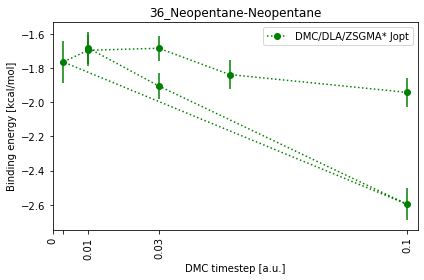

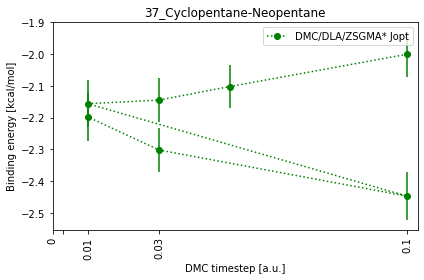

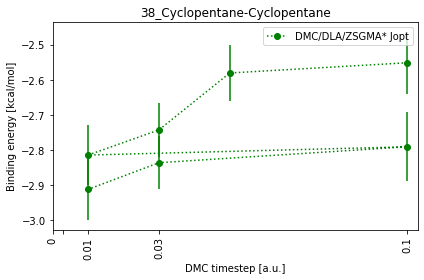

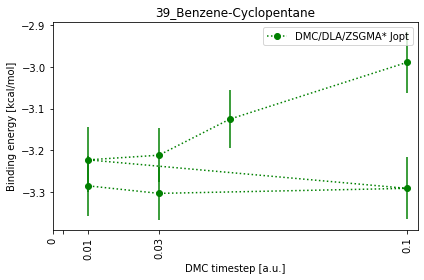

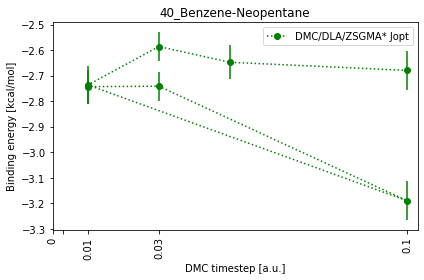

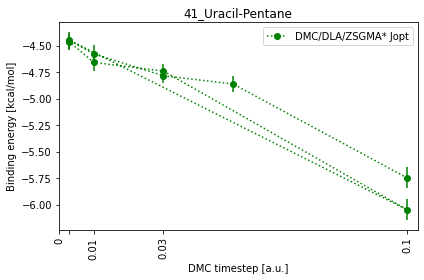

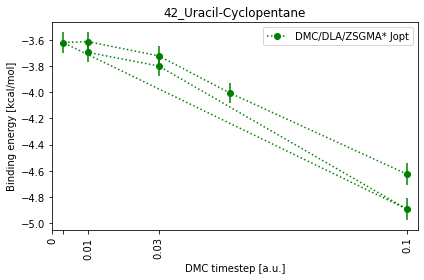

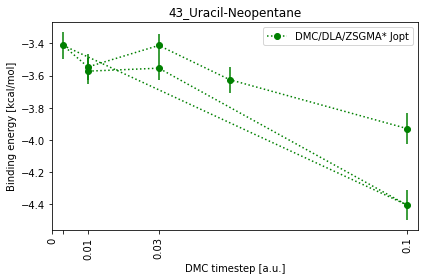

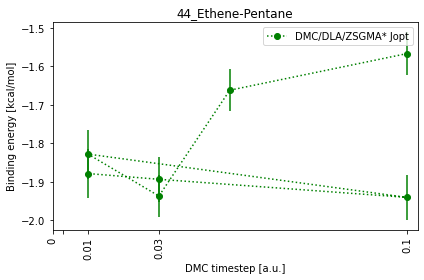

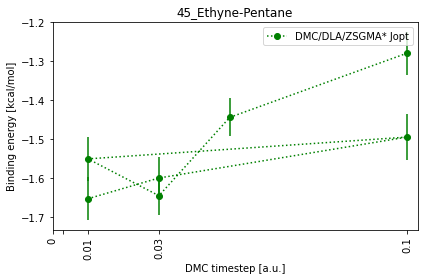

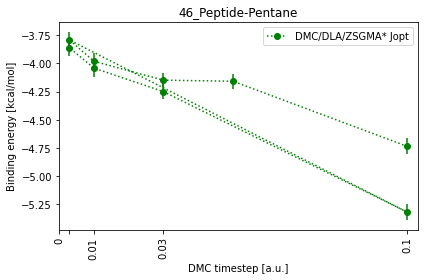

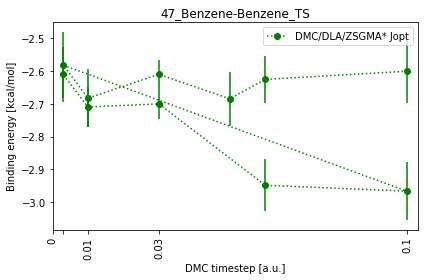

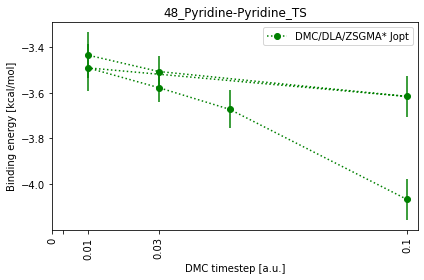

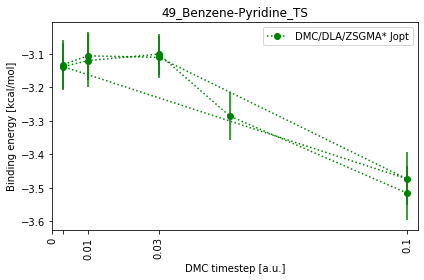

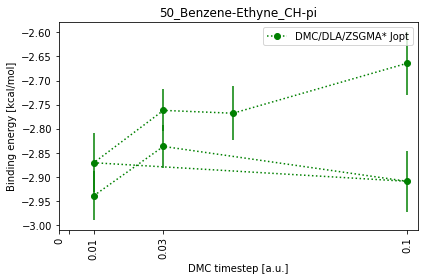

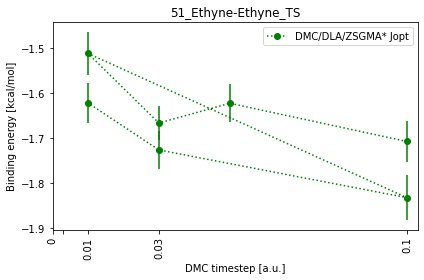

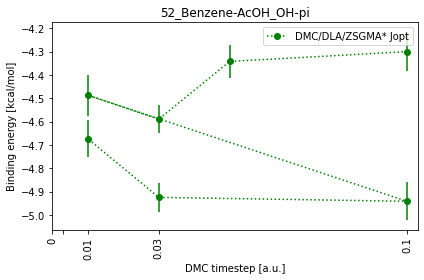

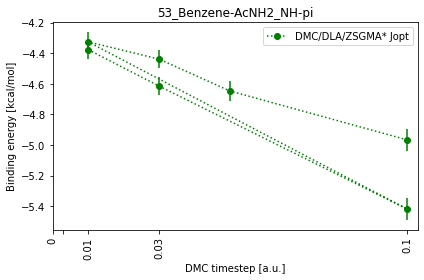

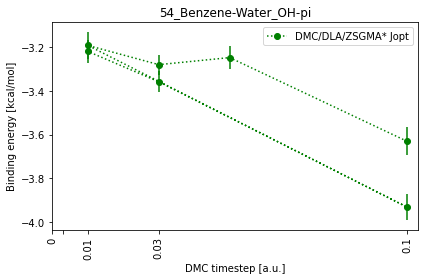

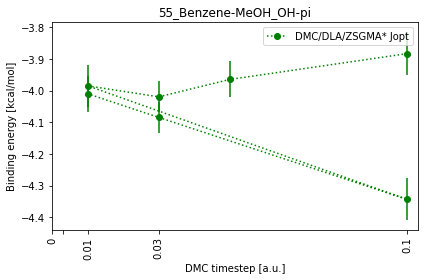

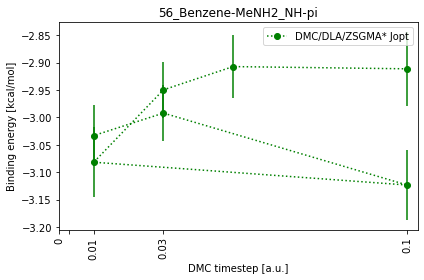

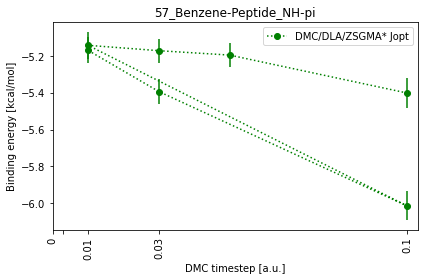

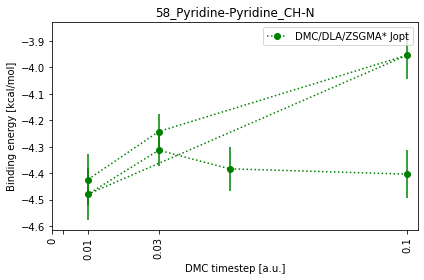

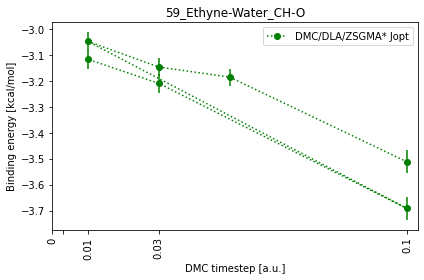

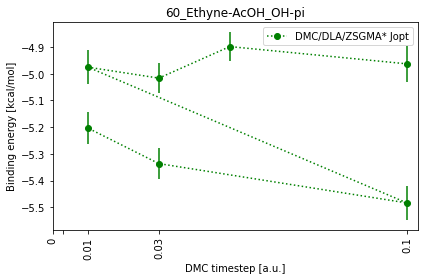

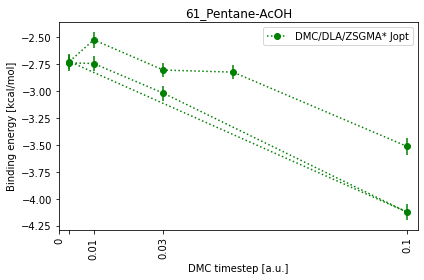

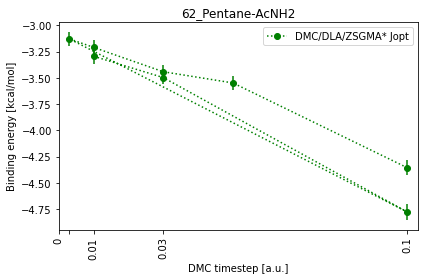

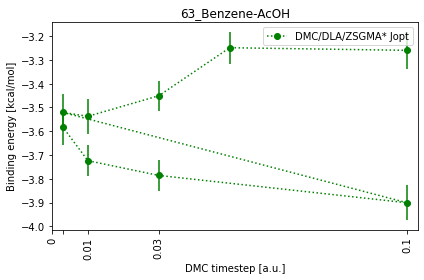

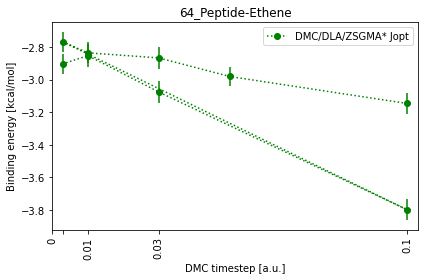

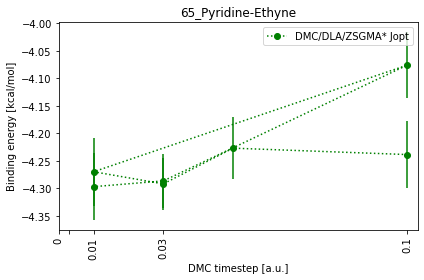

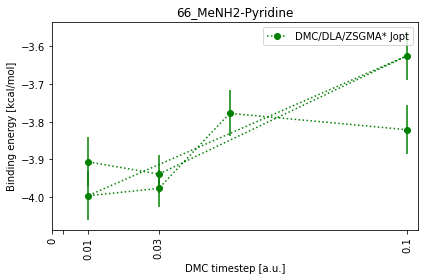

In [21]:
# Plot Binding Energy for 66 dimers using dataframe Eb_1ref
verbose = False

for i in range(1,67):
    d = Eb_1ref[ Eb_1ref['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Binding energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    for dmc_type in dmc_types:
        dd = d[ d['dmc_type']==dmc_type ]
        Jas_set = set( dd['Jas'] )
        for Jas in Jas_set:
            print( f'{i} {dmc_type} {Jas}' )

            ddd = dd[ dd['Jas']==Jas ]
            X = ddd['tau']
            Y = ddd['ene']
            Yerr = ddd['err']
            label = f'{map_DMC(dmc_type)} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o:', label=label , color=c )

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03a/Eb1ref_{i}.png',format='png',dpi=300)